In [1]:
import numpy as  np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader, Dataset
from pmdarima import auto_arima # pip install pmdarima


# Model classes

## LSTM model

In [2]:
class ClassicalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, S): #S: step number
        super(ClassicalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, S)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_hidden = lstm_out[:, -1, :]
        return self.fc(final_hidden)

## ANFIS models

### Ordinary ANFIS Model

In [ ]:
class ClassicalANFIS(nn.Module):
    def __init__(self, num_inputs, num_mfs):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs

        self.mu = nn.Parameter(torch.randn(num_inputs, num_mfs))
        self.sigma = nn.Parameter(torch.ones(num_inputs, num_mfs))

        self.a = nn.Parameter(torch.randn(num_inputs, num_mfs))
        self.b = nn.Parameter(torch.randn(num_inputs, num_mfs))

    def forward(self, x):

        if x.ndim == 3 and x.shape[-1] == 1:
            x = x.squeeze(-1)  # (batch_size, num_inputs, 1) → (batch_size, num_inputs)

        # x : (batch_size, num_inputs)
        batch_size = x.shape[0]
        x_expanded = x.unsqueeze(2)  # (batch_size, num_inputs, 1)

        mu = self.mu.unsqueeze(0)        # (1, num_inputs, num_mfs)
        sigma = self.sigma.unsqueeze(0)  # (1, num_inputs, num_mfs)

        # Gaussian MFs
        mf_values = torch.exp(-((x_expanded - mu) ** 2) / (2 * sigma ** 2))  # (batch_size, num_inputs, num_mfs)

        a = self.a.unsqueeze(0)
        b = self.b.unsqueeze(0)
        rule_outputs = a * x_expanded + b  # (batch_size, num_inputs, num_mfs)

        weighted_outputs = mf_values * rule_outputs  # (batch_size, num_inputs, num_mfs)
        weighted_sum = weighted_outputs.sum(dim=2)   # (batch_size, num_inputs)
        weights_sum = mf_values.sum(dim=2) + 1e-6     # (batch_size, num_inputs)

        normalized = weighted_sum / weights_sum       # (batch_size, num_inputs)
        output = normalized.sum(dim=1, keepdim=True)                # (batch_size,1)

        return output


### ANFIS model used in our ANFIS-LSTM models

In [ ]:
class HybridANFIS(nn.Module):
    def __init__(self, input_dim, num_mfs, rule_type, hidden_dim=8):
        super(HybridANFIS, self).__init__()
        self.input_dim = input_dim
        self.num_mfs = num_mfs
        self.rule_type = rule_type

        self.centers = nn.Parameter(torch.randn(input_dim, num_mfs))  # [input_dim, num_mfs]
        self.sigmas = nn.Parameter(torch.ones(input_dim, num_mfs))    # [input_dim, num_mfs]

        self.rule_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            ) for _ in range(num_mfs)
        ])

        self.linear_rules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 1),
            ) for _ in range(num_mfs)
        ])

    def gaussian_mf(self, x, c, sigma):
        return torch.exp(-0.5 * ((x.unsqueeze(1) - c) / sigma) ** 2)

    def forward(self, x):
        mf_outputs = []
        for i in range(self.input_dim):
            mf_output = self.gaussian_mf(x[:, i], self.centers[i], self.sigmas[i])  # [batch_size, num_mfs]
            mf_outputs.append(mf_output)

        mf_outputs = torch.stack(mf_outputs, dim=1)  # [batch_size, input_dim, num_mfs]
        rule_activations = torch.prod(mf_outputs, dim=1)  # [batch_size, num_mfs]
        norm_activations = rule_activations / torch.sum(rule_activations, dim=1, keepdim=True)

        if(self.rule_type == "NN"):
            rule_outputs = torch.stack([net(x).squeeze(-1) for net in self.rule_nets], dim=1)  # [batch_size, num_mfs]
        elif(self.rule_type == "Linear"):
            rule_outputs = torch.stack([net(x).squeeze(-1) for net in self.linear_rules], dim=1)  # [batch_size, num_mfs]

        output = torch.sum(norm_activations * rule_outputs, dim=1, keepdim=True)  # [batch_size, 1]

        return output

## Hybrid ANFIS-LSTM Model

In [ ]:
class HybridANFISLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim,num_mfs, S,rule_type): # S: number of steps to be forecasted
        super(HybridANFISLSTM, self).__init__()
        self.T = input_dim
        self.anfis_list = nn.ModuleList([HybridANFIS(input_dim,num_mfs,rule_type) for _ in range(input_dim)])
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, S)

    def forward(self, x):
        # x: [batch_size, T, 1] → reshape to [batch_size, T]
        x = x.squeeze(-1)
        denoised = []
        for anfis in self.anfis_list:
            out = anfis(x)  # [batch_size, 1]
            denoised.append(out)
        denoised_x = torch.cat(denoised, dim=1).unsqueeze(-1)  # → [batch_size, T, 1]
        lstm_out, _ = self.lstm(denoised_x)
        final_hidden = lstm_out[:, -1, :]  # Last time step
        out = self.fc(final_hidden)
        return out

## Models to compare our model with

### Naive Model

In [ ]:

class Naive():
    def __init__(self, S):
        self.S = S  # prediction horizon

    def predict(self, X):
        device = X.device 

        last_values = X[:, -1]

        predictions = last_values.view(-1, 1).repeat(1, self.S)

        return predictions.to(device)


### GRU Model

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, horizon, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.horizon = horizon

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, horizon)  

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]            
        out = self.fc(out)             # (batch, S*output_size)
        out = out.view(-1, self.horizon)  # reshape to (batch, S, output_size)
        return out

# Training & Evaluation methods & Data segmentation

### Training method

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs,print_training_details=True, use_mini_batchs = False, batch_size = 64, device = "cpu"):
    train_dataset = TensorDataset(X_train.cpu(), y_train.cpu())
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)

    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    train_losses, val_losses=[],[]
    best_val_loss= float('inf')
    best_parameters= None

    train_losses,val_losses= [],[]

    for epoch in range(epochs):
        if(use_mini_batchs):
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                model.train()
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        else:
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs= model(X_val)
            val_loss= criterion(val_outputs,y_val)
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

        if val_loss.item() < best_val_loss:
            best_val_loss=val_loss.item()
            best_parameters= {k: v.clone() for k, v in model.state_dict().items()}


        if ((epoch+1) % 10 == 0 or epoch+1 == 1) and print_training_details:
            print(f"Epoch [{epoch+1}/{epochs}], Train loss: {loss.item():.4f}, Val loss: {val_loss.item():.4f}")


    model.load_state_dict(best_parameters)
    return model, train_losses, val_losses

### Evaluation methods

In [11]:
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X)
        loss = torch.mean((preds - y) ** 2)
    return preds, loss

In [12]:

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return f"mse: {mse:5f}. mae: {mae:5f}. rmse: {rmse:5f}. r2: {r2:5f}"

In [13]:
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse).item()
    r2 = r2_score(y_true, y_pred)

    return [mse, mae, rmse, r2]

### Train and compare models

In [ ]:
def compare_models_on_diferent_step_values(data, T, max_steps, hidden_dim, num_mfs, device):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    
    metrics_matrix_ANFIS = []
    metrics_matrix_LSTM = []
    metrics_matrix_ANFIS_LSTM_linear = []
    metrics_matrix_ANFIS_LSTM_NN = []
    metrics_matrix_naive = []
    metrics_matrix_GRU = []
    metrics_matrix_ARIMA = []

    for i in range(1, max_steps+1):
        print("###################################")
        S = i
        print(f"Iteration: {S} / {max_steps}")

        X, y = create_sequences(data_scaled, T, S)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)
        y_test_inv = scaler.inverse_transform(y_test)

        X_train = torch.tensor(X_train, dtype=torch.float32, device = device)
        y_train = torch.tensor(y_train, dtype=torch.float32, device = device)
        X_test = torch.tensor(X_test, dtype = torch.float32, device = device)
        y_test = torch.tensor(y_test, dtype = torch.float32, device = device)
        X_val = torch.tensor(X_val, dtype=torch.float32, device = device)
        y_val = torch.tensor(y_val, dtype=torch.float32, device = device)


        print("LSTM...")
        LSTM = ClassicalLSTM(T, hidden_dim, S)
        LSTM = LSTM.to(device)
        LSTM,  _, _  = train_model(LSTM, X_train, y_train, X_val, y_val, epochs = 100, print_training_details = False, device = device)
        preds, _ = evaluate_model(LSTM, X_test, y_test)
        preds = preds.cpu().numpy()
        preds_inv = scaler.inverse_transform(preds)
        metrics = get_metrics(y_test_inv, preds_inv)
        metrics_matrix_LSTM.append(metrics)


        print("ANFIS_LSTM linear...")
        ANFIS_LSTM_linear = HybridANFISLSTM(T, hidden_dim,num_mfs, S,"Linear")
        ANFIS_LSTM_linear = ANFIS_LSTM_linear.to(device)
        ANFIS_LSTM_linear, _, _ = train_model(ANFIS_LSTM_linear, X_train, y_train,X_val, y_val,epochs = 100, print_training_details = False, device = device)
        preds, _ = evaluate_model(ANFIS_LSTM_linear, X_test, y_test)
        preds = preds.cpu().numpy()
        preds_inv = scaler.inverse_transform(preds)
        metrics = get_metrics(y_test_inv, preds_inv)
        metrics_matrix_ANFIS_LSTM_linear.append(metrics)



        print("ANFIS_LSTM NN...")
        ANFIS_LSTM_NN = HybridANFISLSTM(T, hidden_dim,num_mfs, S,"NN")
        ANFIS_LSTM_NN = ANFIS_LSTM_NN.to(device)
        ANFIS_LSTM_NN, _, _ = train_model(ANFIS_LSTM_NN, X_train, y_train,X_val, y_val,epochs = 100, print_training_details = False, device = device)
        preds, _ = evaluate_model(ANFIS_LSTM_NN, X_test, y_test)
        preds = preds.cpu().numpy()
        preds_inv = scaler.inverse_transform(preds)
        metrics = get_metrics(y_test_inv, preds_inv)
        metrics_matrix_ANFIS_LSTM_NN.append(metrics)


        print("GRU...")
        GRU = GRUModel(input_size=1, hidden_size=hidden_dim, horizon=S)
        GRU = GRU.to(device)
        GRU,  _, _  = train_model(GRU, X_train, y_train, X_val, y_val, epochs = 100, print_training_details = False, device = device)
        preds, _ = evaluate_model(GRU, X_test, y_test)
        preds = preds.cpu().numpy()
        preds_inv = scaler.inverse_transform(preds)
        metrics = get_metrics(y_test_inv, preds_inv)
        metrics_matrix_GRU.append(metrics)


        print("Naive...")
        naive = Naive(S)
        preds = naive.predict(X_test)
        preds = preds.cpu().numpy()
        preds_inv = scaler.inverse_transform(preds)
        metrics = get_metrics(y_test_inv, preds_inv)
        metrics_matrix_naive.append(metrics)


        print("ARIMA...")
        X_test = X_test.cpu().numpy()
        y_test = y_test.cpu().numpy()
        predictions = []
        j = 0
        for x_j, y_j in zip(X_test, y_test):
          j += 1
          if ((j) % 50 == 0 or j == 1 or j == X_test.shape[0]) & False:
            print(f"ARIMA iteration num: {j} / {X_test.shape[0]}")
          model = auto_arima(x_j,
                            start_p=0, max_p=3,
                            start_q=0, max_q=3,
                            d=None,
                            seasonal=False,
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
          y_hat = model.predict(n_periods=len(y_j))
          predictions.append(y_hat)

        preds_inv = scaler.inverse_transform(predictions)
        metrics = get_metrics(y_test_inv, preds_inv)
        metrics_matrix_ARIMA.append(metrics)

    print("###################################\nComparing models finished successfully\n###################################")
    return np.array(metrics_matrix_ANFIS), np.array(metrics_matrix_LSTM), np.array(metrics_matrix_ANFIS_LSTM_linear), np.array(metrics_matrix_ANFIS_LSTM_NN), np.array(metrics_matrix_naive), np.array(metrics_matrix_GRU), np.array(metrics_matrix_ARIMA)


### Create sequences from linear data

In [15]:
def create_sequences(data, T,S):
    X, y = [], []
    for i in range(len(data) - T - S):
        X.append(data[i:i+T])
        y.append(data[i+T: i + T + S])
    X = np.array(X)
    y = np.array(y).squeeze(-1)

    return X, y

### Selecting device and mountinig to drive

In [16]:
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda:0


# Hyper parameters

In [10]:
max_steps = 20
T = 10
hidden_dim = 20
num_mfs = 30

# Coparing models with different S values on **Synthetic** data



## Synthetic Data

In [43]:
timesteps = torch.linspace(0, 100, 1000)
data = torch.sin(timesteps)+ 2*torch.cos(timesteps/50)+ 2*torch.cos(timesteps/100) + torch.randn(size=(len(timesteps),))*0.2*torch.cos(200*timesteps)
data = data.reshape(-1, 1)

## Compare models

In [ ]:
metrics_matrix_ANFIS, metrics_matrix_LSTM, metrics_matrix_ANFIS_LSTM_linear, metrics_matrix_ANFIS_LSTM_NN, metrics_matrix_naive, metrics_matrix_GRU, metrics_matrix_ARIMA = compare_models_on_diferent_step_values(data, T, max_steps,hidden_dim,num_mfs, device)

## Ploting comparision results

### MSE

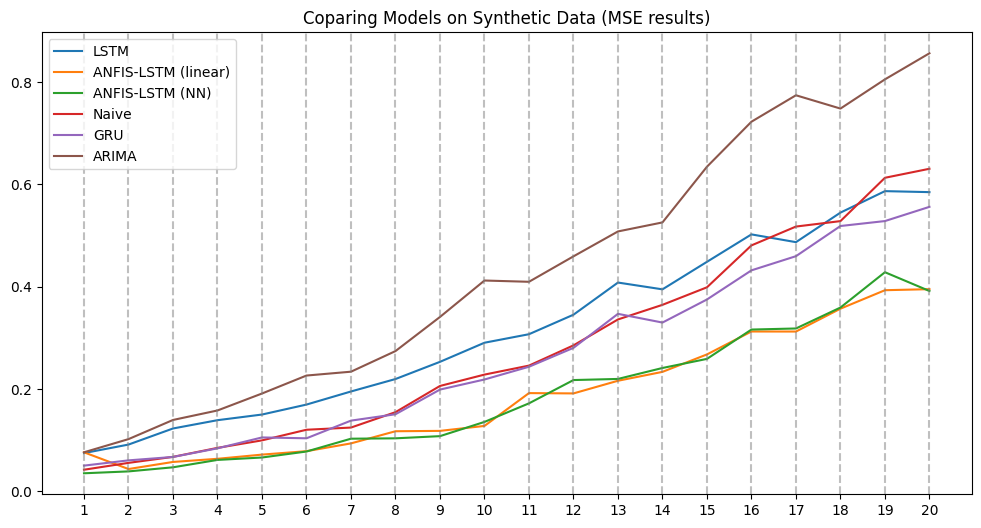

In [46]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:,0], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:,0], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:,0], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:,0], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:,0], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:,0], label = "ARIMA")
plt.title("Coparing Models on Synthetic Data (MSE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### MAE

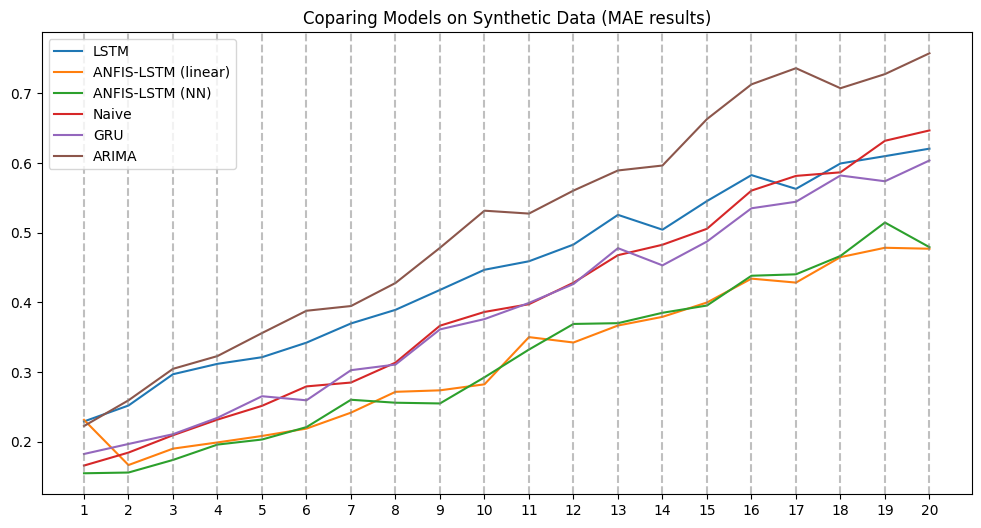

In [47]:
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:,1], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:,1], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:,1], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:,1], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:,1], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:,1], label = "ARIMA")
plt.title("Coparing Models on Synthetic Data (MAE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### RMSE

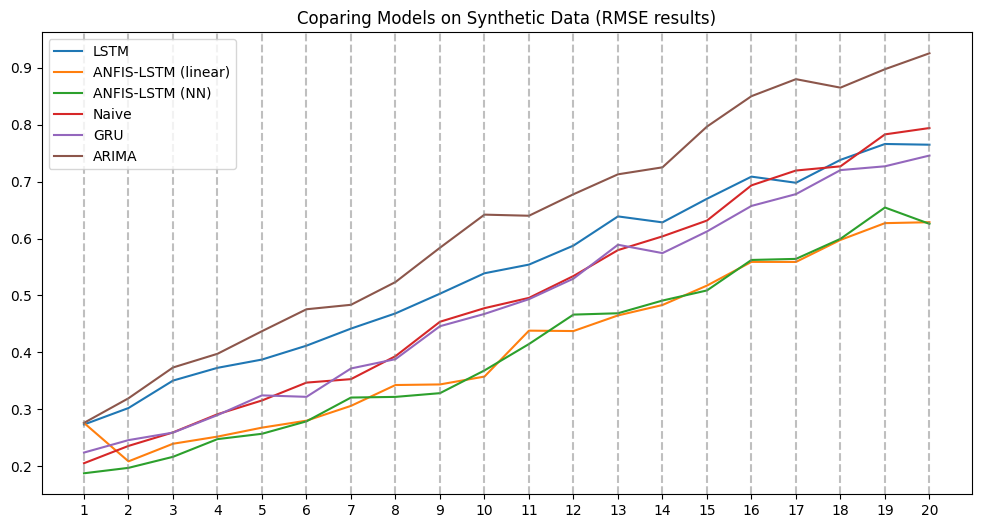

In [48]:
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:, 2], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:, 2], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:, 2], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:, 2], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:, 2], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:, 2], label = "ARIMA")
plt.title("Coparing Models on Synthetic Data (RMSE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### $R^{2}$

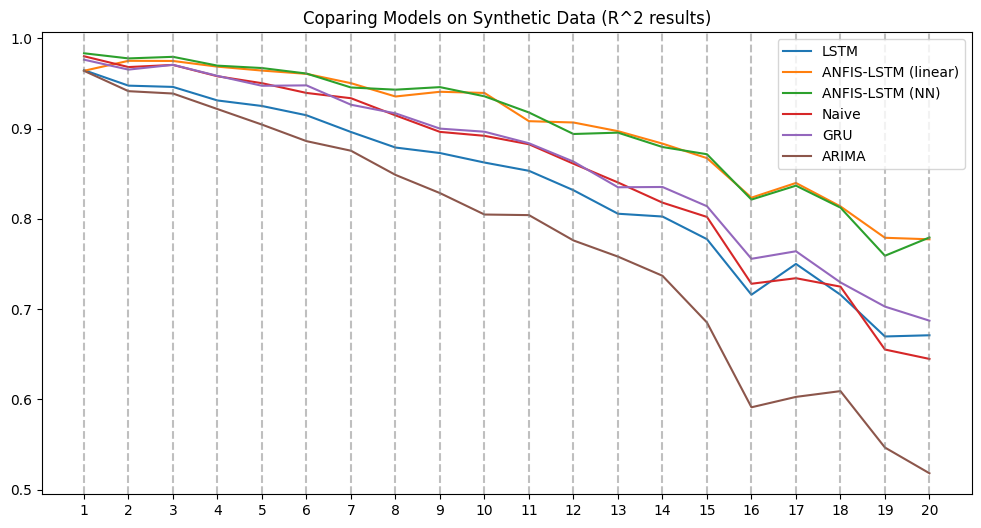

In [49]:
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:, 3], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:, 3], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:, 3], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:, 3], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:, 3], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:, 3], label = "ARIMA")
plt.title("Coparing Models on Synthetic Data (R^2 results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Coparing models with different S values on **Weather data**

## Data

In [ ]:
weather_data_path = "/home/muhammedyilmaz/Desktop/YUM/Muhamed/ankara 2023-01-25 to 2025-06-12.csv"
df = pd.read_csv(weather_data_path)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
data = df[['temp']].dropna()

## Coparing models

In [ ]:
metrics_matrix_ANFIS, metrics_matrix_LSTM, metrics_matrix_ANFIS_LSTM_linear, metrics_matrix_ANFIS_LSTM_NN, metrics_matrix_naive, metrics_matrix_GRU, metrics_matrix_ARIMA = compare_models_on_diferent_step_values(data, T, max_steps,hidden_dim,num_mfs, device)

## Ploting comparision results

### MSE

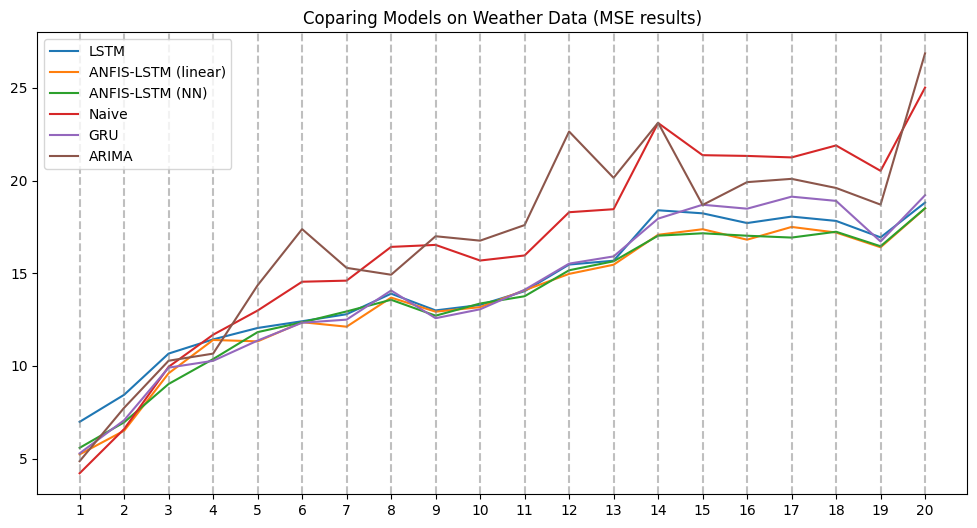

In [53]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:,0], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:,0], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:,0], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:,0], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:,0], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:,0], label = "ARIMA")
plt.title("Coparing Models on Weather Data (MSE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### MAE

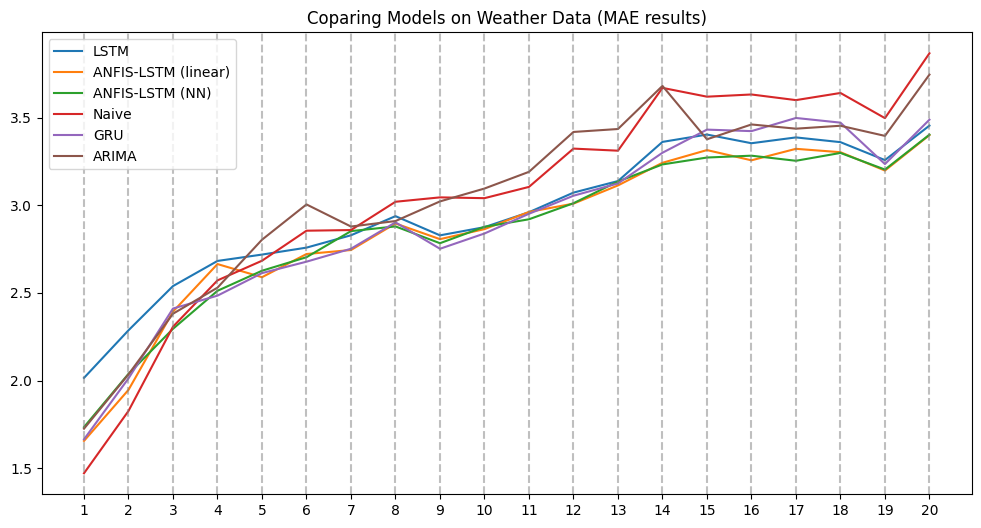

In [54]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:,1], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:,1], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:,1], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:,1], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:,1], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:,1], label = "ARIMA")
plt.title("Coparing Models on Weather Data (MAE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### RMSE

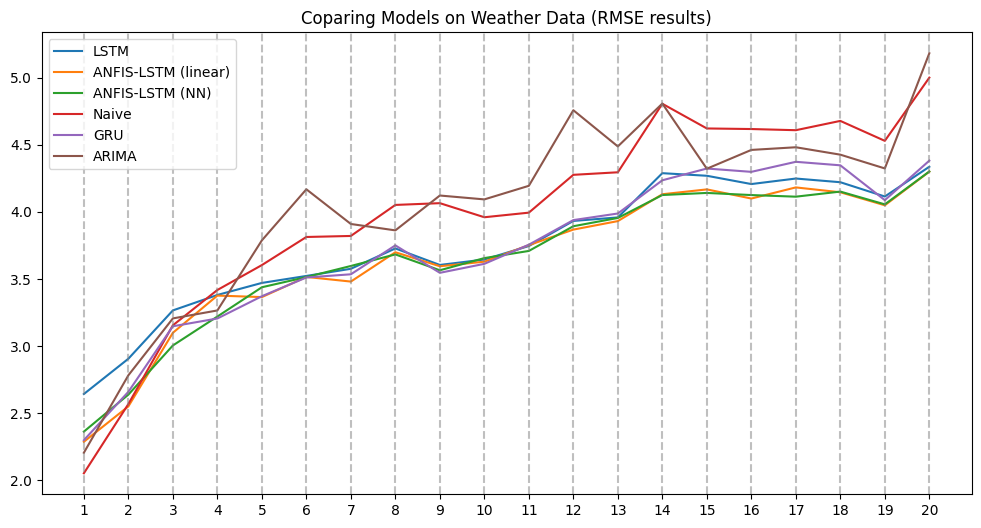

In [55]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:, 2], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:, 2], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:, 2], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:, 2], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:, 2], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:, 2], label = "ARIMA")
plt.title("Coparing Models on Weather Data (RMSE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### $R^{2}$

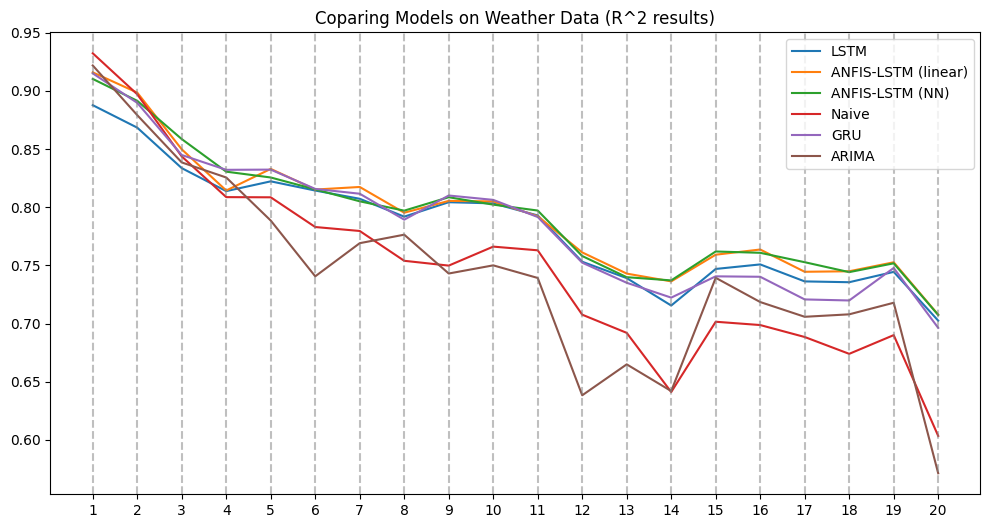

In [56]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:, 3], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:, 3], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:, 3], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:, 3], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:, 3], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:, 3], label = "ARIMA")
plt.title("Coparing Models on Weather Data (R^2 results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Coparing models with different S values on **BorsaIstanbul XU100** data

## BorsaIstanbul XU100 Data

In [57]:
borsaIstanbul_XU100_data_path = "/home/muhammedyilmaz/Desktop/YUM/Muhamed/BIST100_XU100.csv"
df = pd.read_csv(borsaIstanbul_XU100_data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Extract and scale only the 'temp' column
data = df[['High']].dropna()

## Coparing models

In [ ]:
metrics_matrix_ANFIS, metrics_matrix_LSTM, metrics_matrix_ANFIS_LSTM_linear, metrics_matrix_ANFIS_LSTM_NN, metrics_matrix_naive, metrics_matrix_GRU, metrics_matrix_ARIMA = compare_models_on_diferent_step_values(data, T, max_steps,hidden_dim,num_mfs, device)

## Ploting comparision results

### MSE

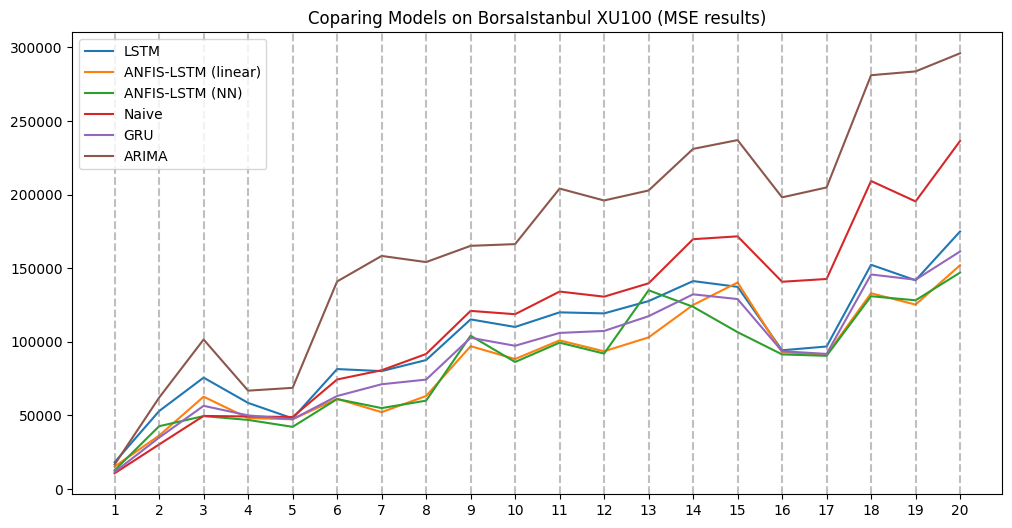

In [60]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:,0], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:,0], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:,0], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:,0], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:,0], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:,0], label = "ARIMA")
plt.title("Coparing Models on BorsaIstanbul XU100 (MSE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### MAE

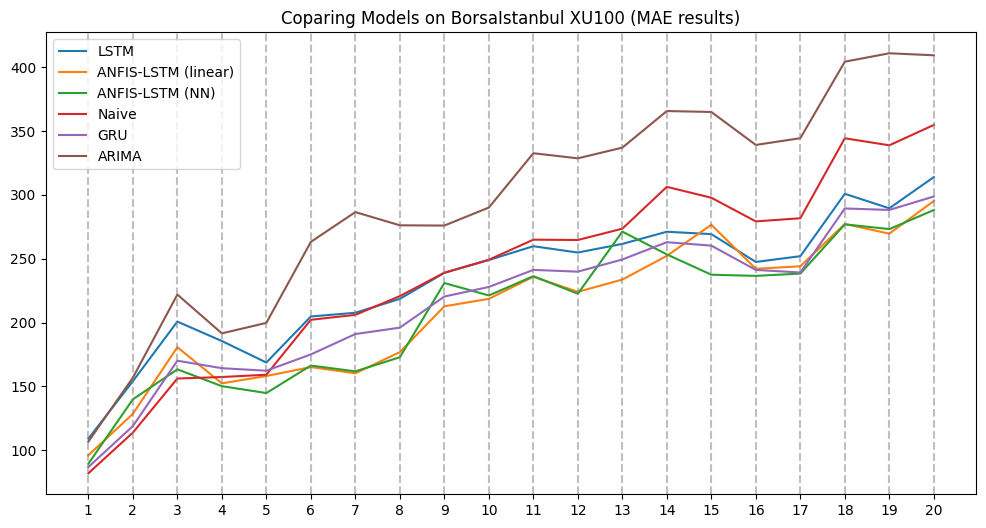

In [61]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:,1], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:,1], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:,1], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:,1], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:,1], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:,1], label = "ARIMA")
plt.title("Coparing Models on BorsaIstanbul XU100 (MAE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### RMSE

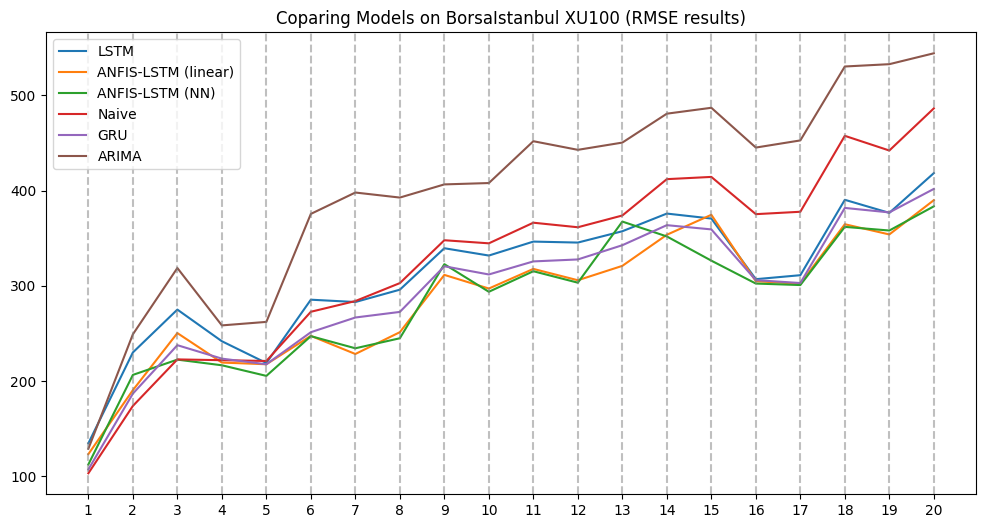

In [62]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:, 2], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:, 2], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:, 2], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:, 2], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:, 2], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:, 2], label = "ARIMA")
plt.title("Coparing Models on BorsaIstanbul XU100 (RMSE results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### $R^{2}$

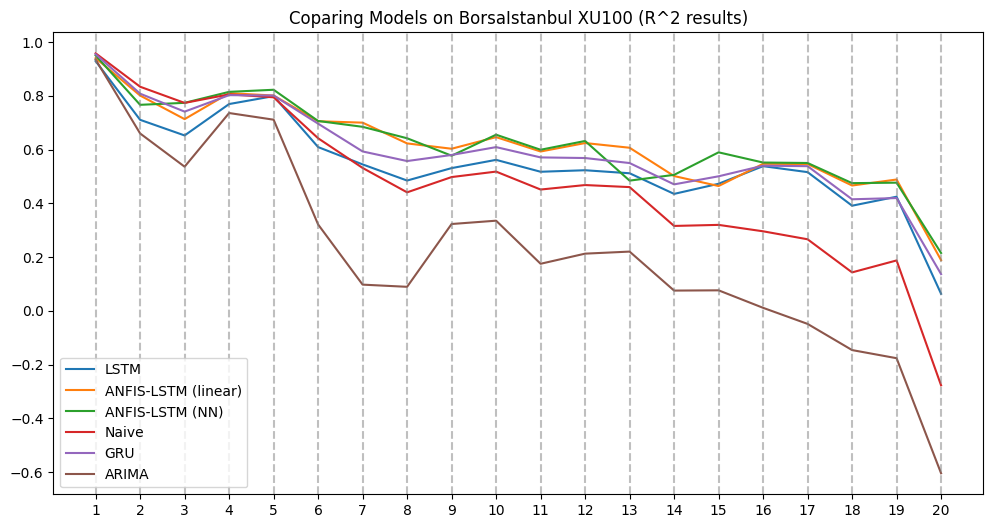

In [63]:
x = np.array(range(1,max_steps + 1))
plt.figure(figsize = (12,6))
plt.plot(x,metrics_matrix_LSTM[:, 3], label = "LSTM")
plt.plot(x, metrics_matrix_ANFIS_LSTM_linear[:, 3], label = "ANFIS-LSTM (linear)")
plt.plot(x, metrics_matrix_ANFIS_LSTM_NN[:, 3], label = "ANFIS-LSTM (NN)")
plt.plot(x, metrics_matrix_naive[:, 3], label = "Naive")
plt.plot(x, metrics_matrix_GRU[:, 3], label = "GRU")
plt.plot(x, metrics_matrix_ARIMA[:, 3], label = "ARIMA")
plt.title("Coparing Models on BorsaIstanbul XU100 (R^2 results)")
plt.xticks(x)
for pos in x:
    plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.show()